In [91]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
from datetime import datetime
import statsmodels.formula.api as smf

from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from pylab import mpl
import platform

# 根据操作系统设置中文字体
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
elif system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS使用Arial Unicode MS
    plt.rcParams['axes.unicode_minus'] = False
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # Linux使用文泉驿微米黑
    plt.rcParams['axes.unicode_minus'] = False

# 输出矢量图
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 设置pandas显示选项
pd.set_option('display.max_columns', None)

print(f"当前操作系统: {system}")
print(f"字体设置: {plt.rcParams['font.sans-serif']}")

当前操作系统: Windows
字体设置: ['SimHei']


In [92]:
cross = pd.read_csv(r'C:\Users\冤种千斤\Desktop\代码\第十三次作业\TRD_Mnth202509.csv')
from pandas.tseries.offsets import MonthEnd
# 处理月份格式
cross['month'] = pd.to_datetime(cross['Trdmnt'], format='%Y-%m') + MonthEnd(1)
# 补齐股票代码 如果不满6位 在前面补上0
cross['Stkcd'] = cross['Stkcd'].apply(lambda x: '{:0>6}'.format(x)) # 6位股票代码
# 重命名列以匹配后续代码
cross.rename(columns={'Mretwd': 'Return', 'Msmvosd': 'floatingvalue', 'Msmvttl': 'totalvalue'}, inplace=True)

# 导入无风险利率数据
rf_data = pd.read_csv('Marketret_mon_stock2024.csv')
# 处理月份格式
rf_data['month'] = pd.to_datetime(rf_data['month'], format='%b %Y') + MonthEnd(1)
# 只保留需要的列
rf_data = rf_data[['month', 'rfmonth']]

# 合并无风险利率到cross
cross = pd.merge(cross, rf_data, on='month', how='left')

# 添加一个序列 用来统计公司上市的第几个月
cross = cross.sort_values(by=['Stkcd', 'month'])
cross['list_month'] = cross.groupby('Stkcd').cumcount() + 1

# 计算超额收益率
cross['ret'] = cross['Return'] - cross['rfmonth']
cross['floatingvalue'] = cross['floatingvalue'] * 1000
cross['totalvalue'] = cross['totalvalue'] * 1000

cross#调用两个表格数据，将其合并

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret
0,000001,1991-04,3,49.00,30,43.68,13400,6.150000e+05,1.157520e+09,2.118487e+09,20,NaN,NaN,4,1991-04-03,NaN,NaN,1991-04-30,0.006651,1,NaN
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,2,-0.128345
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,3,-0.119551
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,4,-0.137013
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,5,-0.417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886908,920992,2025-05,6,20.00,30,20.46,92609592,1.922463e+09,5.707967e+08,1.979115e+09,19,0.051312,0.051715,64,2023-04-25,0.0,0.0,2025-05-31,NaN,32,NaN
886909,920992,2025-06,3,20.40,30,21.26,73152031,1.580767e+09,5.931152e+08,2.056500e+09,20,0.039101,0.039101,64,2023-04-25,0.0,0.0,2025-06-30,NaN,33,NaN
886910,920992,2025-07,1,21.13,31,22.44,96064221,2.126994e+09,6.260351e+08,2.170642e+09,23,0.055503,0.055503,64,2023-04-25,0.0,0.0,2025-07-31,NaN,34,NaN
886911,920992,2025-08,1,22.12,29,21.65,63953451,1.432608e+09,6.039955e+08,2.094225e+09,21,-0.035205,-0.035205,64,2023-04-25,0.0,0.0,2025-08-31,NaN,35,NaN


In [93]:
# 生成下一个月的收益率

# 方法1：补全所有个股的日期序列，再使用shift
# 创建所有日期和股票代码的完整组合
all_months = pd.DataFrame(cross['month'].unique(), columns=['month'])
all_stocks = pd.DataFrame(cross['Stkcd'].unique(), columns=['Stkcd'])
# 创建笛卡尔积 - 所有股票和所有月份的组合
full_index = all_stocks.merge(all_months, how='cross')

# 将原始数据合并到完整索引中
cross_full = full_index.merge(cross, on=['Stkcd', 'month'], how='left')
# 按股票代码和月份排序
cross_full = cross_full.sort_values(['Stkcd', 'month'])
# 使用shift生成下月收益率
cross_full['next_ret'] = cross_full.groupby('Stkcd')['ret'].shift(-1)

# 只保留原始数据存在的行
cross = cross.merge(cross_full[['Stkcd', 'month', 'next_ret']], 
                    on=['Stkcd', 'month'], how='right')

# 添加一个变量 用来统计过去一年的交易日数量之和
cross['Cumsum_tradingday'] = cross.groupby('Stkcd')['Ndaytrd'].transform(lambda x: x.rolling(window=12, min_periods=1).sum())
print("方法1完成：补全日期序列后使用shift")

cross = cross[(cross['month'] >= '1995-01-31') & (cross['month'] <= '2024-12-31')]
cross

方法1完成：补全日期序列后使用shift


,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday
49,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0
50,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0
51,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0
52,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0
53,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2453228,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0
2453229,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0
2453230,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0
2453231,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0


In [94]:
from pandas.tseries.offsets import MonthEnd # 月末
Market_ret = pd.read_csv('Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret.rename(columns={'ret': 'MKT'}, inplace=True)
Market_ret

,MarketR,MarketR_e,rfmonth,MKT,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [95]:
cross = pd.merge(cross,Market_ret[['MKT']],left_on='month',right_on='month',how='left')
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112835,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0,-0.032586
2112836,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0,0.194874
2112837,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0,-0.004527
2112838,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0,0.008606


In [96]:
# 重新读取EP数据并转换month列
EP = pd.read_csv('EP_individual_mon2024.csv')
EP['Stkcd'] = EP['Stkcd'].apply(lambda x: '{:0>6}'.format(x))

# 转换month列为日期格式
# 根据数据规律：1991.258080 -> 1991年3月，1991.333333 -> 1991年4月
# 小数部分 = (month - 1) / 12, 所以 month = round(小数部分 * 12) + 1
EP['year'] = EP['month'].astype(int)
EP['month_decimal'] = EP['month'] - EP['year']
EP['month_num'] = (EP['month_decimal'] * 12).round().astype(int) + 1
# 处理边界情况
EP.loc[EP['month_num'] > 12, 'year'] += 1
EP.loc[EP['month_num'] > 12, 'month_num'] -= 12
EP['month'] = pd.to_datetime(EP['year'].astype(str) + '-' + EP['month_num'].astype(str) + '-01')
EP = EP.drop(['year', 'month_decimal', 'month_num'], axis=1)
EP['month'] = EP['month'] + pd.offsets.MonthEnd(1)
# 修正列选择 - 应该使用列表选择列
EP = EP[['Stkcd', 'month', 'ep', 'ep_recent']]
EP

,Stkcd,month,ep,ep_recent
0,000001,1991-04-30,NaN,NaN
1,000001,1991-05-31,NaN,NaN
2,000001,1991-06-30,NaN,NaN
3,000001,1991-07-31,NaN,NaN
4,000001,1991-08-31,NaN,NaN
...,...,...,...,...
809599,605599,2024-08-31,0.079184,0.046498
809600,605599,2024-09-30,0.071525,0.042001
809601,605599,2024-10-31,0.077932,0.063816
809602,605599,2024-11-30,0.072171,0.059100


In [97]:
cross = pd.merge(cross,EP[['Stkcd','month','ep','ep_recent']],on=['Stkcd','month'],how='left')
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112835,920992,2024-08,1.0,8.50,30.0,8.19,14436632.0,1.185912e+08,2.284861e+08,7.922264e+08,22.0,-0.037603,-0.037603,64.0,2023-04-25,0.0,0.0,2024-08-31,0.001118,23.0,-0.038721,0.276049,242.0,-0.032586,NaN,NaN
2112836,920992,2024-09,2.0,8.15,30.0,10.46,18109819.0,1.566140e+08,2.918149e+08,1.011806e+09,19.0,0.277167,0.277167,64.0,2023-04-25,0.0,0.0,2024-09-30,0.001118,24.0,0.276049,0.389895,241.0,0.194874,NaN,NaN
2112837,920992,2024-10,8.0,13.02,31.0,14.55,86774237.0,1.145494e+09,4.059185e+08,1.407435e+09,18.0,0.391013,0.391013,64.0,2023-04-25,0.0,0.0,2024-10-31,0.001118,25.0,0.389895,0.241494,242.0,-0.004527,NaN,NaN
2112838,920992,2024-11,1.0,14.69,29.0,18.08,130783392.0,2.346534e+09,5.043990e+08,1.748895e+09,21.0,0.242612,0.242612,64.0,2023-04-25,0.0,0.0,2024-11-30,0.001118,26.0,0.241494,-0.243928,241.0,0.008606,NaN,NaN


In [98]:
# 计算每个月份总市值的三分位数（30%分位数）
fenweishu = pd.DataFrame(
    cross.groupby(['month'])['totalvalue'].quantile(0.3)  # 按月份分组，对每个组计算30%分位数
)

# 重命名列，使其含义更明确
fenweishu.columns = ['fenweishu_guimo']  # "分位数_规模" - 表示规模的三分位数阈值

fenweishu

,fenweishu_guimo
month,
1995-01-31,3.958033e+08
1995-02-28,3.907805e+08
1995-03-31,4.341120e+08
1995-04-30,3.835094e+08
1995-05-31,4.590161e+08
...,...
2024-08-31,2.442662e+09
2024-09-30,3.012217e+09
2024-10-31,3.234660e+09


In [99]:
cross_new = pd.merge(cross,fenweishu,on='month',how='left')
cross_new = cross_new[cross_new['totalvalue'] > cross_new['fenweishu_guimo']]
cross_new

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,3.958033e+08
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763,3.907805e+08
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823,4.341120e+08
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306,3.835094e+08
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349,4.590161e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2112451,920985,2022-08,8.0,11.05,31.0,11.43,245414411.0,3.490897e+09,1.352501e+09,3.445035e+09,18.0,NaN,NaN,64.0,2022-08-08,0.0,0.0,2022-08-31,0.001241,1.0,NaN,-0.124667,18.0,-0.020875,NaN,NaN,3.370444e+09
2112452,920985,2022-09,1.0,11.60,30.0,10.02,69513984.0,7.992666e+08,1.185657e+09,3.100952e+09,21.0,-0.123360,-0.123360,64.0,2022-09-06,0.0,0.0,2022-09-30,0.001307,2.0,-0.124667,0.025581,39.0,-0.065953,NaN,NaN,3.024944e+09
2112453,920985,2022-10,10.0,10.06,31.0,10.29,33100688.0,3.486847e+08,1.217606e+09,3.184510e+09,16.0,0.026946,0.026946,64.0,2022-09-06,0.0,0.0,2022-10-31,0.001365,3.0,0.025581,-0.014970,55.0,-0.042599,NaN,NaN,3.165959e+09
2112477,920985,2024-10,8.0,8.60,31.0,15.31,486954437.0,5.439326e+09,2.058722e+09,4.738081e+09,18.0,1.261448,1.261448,64.0,2023-02-22,0.0,0.0,2024-10-31,0.001118,27.0,1.260330,-0.157878,242.0,-0.004527,NaN,NaN,3.234660e+09


In [100]:
cross_new = cross_new[cross_new['Ndaytrd'] >= 12]
# cross_new = cross_new[cross_new['Clsdt'] >= 5]
cross_new = cross_new[cross_new['list_month'] > 6]
cross_new = cross_new[cross_new['Cumsum_tradingday'] >= 120]
cross_new = cross_new[(cross_new['Markettype'] == 1) | (cross_new['Markettype'] == 4) | (cross_new['Markettype'] == 16)] # 上海A 深圳A 创业板
# ep是完整的
cross_new = cross_new.dropna(subset=['ep'])
cross_new

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,3.958033e+08
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763,3.907805e+08
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823,4.341120e+08
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306,3.835094e+08
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349,4.590161e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779475,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,0.079184,0.046498,2.442662e+09
1779476,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,0.071525,0.042001,3.012217e+09
1779477,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,0.077932,0.063816,3.234660e+09
1779478,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606,0.072171,0.059100,3.392681e+09


In [101]:
guimo = cross_new.groupby(['month'])['totalvalue'].quantile(0.5).to_frame()
guimo.columns = ['guimo']
guimo# 计算每个月份总市值的中位数

,guimo
month,
1995-01-31,8.413909e+08
1995-02-28,8.085674e+08
1995-03-31,9.415474e+08
1995-04-30,8.264294e+08
1995-05-31,9.532519e+08
...,...
2024-08-31,5.863931e+09
2024-09-30,7.218455e+09
2024-10-31,7.787871e+09


In [102]:
jiazhi = cross_new.groupby(['month'])['ep'].quantile([0.3,0.7]).to_frame()
jiazhi.reset_index(inplace=True)
jiazhi = jiazhi.pivot_table(index='month',columns='level_1',values='ep')
jiazhi.columns = ['jiazhi_30','jiazhi_70']
jiazhi# 计算每个月份EP的30%和70%分位数

,jiazhi_30,jiazhi_70
month,,
1995-01-31,0.028942,0.079487
1995-02-28,0.033836,0.075549
1995-03-31,0.028213,0.062519
1995-04-30,0.037206,0.086090
1995-05-31,0.030822,0.072632
...,...,...
2024-08-31,0.008065,0.051295
2024-09-30,0.005733,0.042326
2024-10-31,0.003594,0.040937


In [103]:
cross_new = pd.merge(cross_new,guimo,on='month',how='left')
cross_new = pd.merge(cross_new,jiazhi,on='month',how='left')
cross_new# 合并中位数和分位数数据

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo,guimo,jiazhi_30,jiazhi_70
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,3.958033e+08,8.413909e+08,0.028942,0.079487
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763,3.907805e+08,8.085674e+08,0.033836,0.075549
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823,4.341120e+08,9.415474e+08,0.028213,0.062519
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306,3.835094e+08,8.264294e+08,0.037206,0.086090
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349,4.590161e+08,9.532519e+08,0.030822,0.072632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499326,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,0.079184,0.046498,2.442662e+09,5.863931e+09,0.008065,0.051295
499327,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,0.071525,0.042001,3.012217e+09,7.218455e+09,0.005733,0.042326
499328,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,0.077932,0.063816,3.234660e+09,7.787871e+09,0.003594,0.040937
499329,605599,2024-11,1.0,10.63,29.0,11.50,108258572.0,1.199394e+09,8.944445e+09,8.944445e+09,21.0,0.079812,0.079812,1.0,2024-09-09,0.0,0.0,2024-11-30,0.001118,39.0,0.078694,-0.014161,241.0,0.008606,0.072171,0.059100,3.392681e+09,8.019636e+09,0.003567,0.039460


In [104]:
# 注意：totalvalue > guimo 的为大市值(B)，否则为小市值(S)
# 注意：ep > jiazhi_70 的为价值股(V)，ep > jiazhi_30 的为中间股(M)，否则为成长股(G)

# 根据市值大小创建规模分类
# totalvalue大于阈值guimo的标记为'B'(Big/大市值)，否则标记为'S'(Small/小市值)
cross_new['size'] = np.where(cross_new['totalvalue'] > cross_new['guimo'], 'B', 'S')

# 根据EP(市盈率倒数)创建价值/成长分类
# 三层嵌套条件：
# 1. ep大于jiazhi_70的为'V'(Value/价值股)
# 2. ep大于jiazhi_30的为'M'(Median/中间股)
# 3. 否则为'G'(Growth/成长股)
cross_new['value'] = np.where(
    cross_new['ep'] > cross_new['jiazhi_70'], 
    'V',
    np.where(
        cross_new['ep'] > cross_new['jiazhi_30'], 
        'M', 
        'G'
    )
)

# 删除关键变量有缺失值的行，确保后续分析的完整性
# 只保留next_ret(下月收益率)和totalvalue(总市值)都不为NaN的行
cross_new = cross_new.dropna(subset=['next_ret', 'totalvalue'])

cross_new

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,list_month,ret,next_ret,Cumsum_tradingday,MKT,ep,ep_recent,fenweishu_guimo,guimo,jiazhi_30,jiazhi_70,size,value
0,000001,1995-01,3.0,10.50,27.0,10.54,17488100.0,1.867690e+08,3.134297e+09,4.543463e+09,19.0,0.005725,0.005725,4.0,1994-09-02,NaN,NaN,1995-01-31,0.008719,46.0,-0.002994,-0.000180,247.0,-0.125017,0.078427,0.078427,3.958033e+08,8.413909e+08,0.028942,0.079487,B,M
1,000001,1995-02,13.0,10.60,28.0,10.63,8544200.0,9.192790e+07,3.161060e+09,4.582260e+09,12.0,0.008539,0.008539,4.0,1994-09-02,NaN,NaN,1995-02-28,0.008719,47.0,-0.000180,0.003511,244.0,-0.022778,0.077763,0.077763,3.907805e+08,8.085674e+08,0.033836,0.075549,B,V
2,000001,1995-03,1.0,10.63,31.0,10.76,18810600.0,2.059094e+08,3.199719e+09,4.638299e+09,23.0,0.012230,0.012230,4.0,1994-09-02,NaN,NaN,1995-03-31,0.008719,48.0,0.003511,-0.108161,244.0,0.122163,0.076823,0.076823,4.341120e+08,9.415474e+08,0.028213,0.062519,B,V
3,000001,1995-04,3.0,10.78,28.0,9.69,13235500.0,1.380604e+08,2.881531e+09,4.177055e+09,20.0,-0.099442,-0.099442,4.0,1994-09-02,NaN,NaN,1995-04-30,0.008719,49.0,-0.108161,0.002633,243.0,-0.113023,0.085306,0.085306,3.835094e+08,8.264294e+08,0.037206,0.086090,B,M
4,000001,1995-05,2.0,9.69,31.0,9.80,53197900.0,6.049730e+08,2.914242e+09,4.224473e+09,22.0,0.011352,0.011352,4.0,1994-09-02,NaN,NaN,1995-05-31,0.008719,50.0,0.002633,-0.073005,244.0,0.166736,0.084349,0.084349,4.590161e+08,9.532519e+08,0.030822,0.072632,B,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499325,605599,2024-07,1.0,12.78,31.0,11.49,54949980.0,6.610917e+08,6.740928e+09,8.936667e+09,23.0,-0.097408,-0.097408,1.0,2022-09-09,0.0,0.0,2024-07-31,0.001184,35.0,-0.098592,-0.066392,243.0,-0.000624,0.078272,0.028314,2.521012e+09,6.148011e+09,0.008836,0.050913,B,V
499326,605599,2024-08,1.0,11.51,30.0,10.74,60492042.0,6.675452e+08,6.300920e+09,8.353334e+09,22.0,-0.065274,-0.065274,1.0,2022-09-09,0.0,0.0,2024-08-31,0.001118,36.0,-0.066392,0.105958,242.0,-0.032586,0.079184,0.046498,2.442662e+09,5.863931e+09,0.008065,0.051295,B,V
499327,605599,2024-09,2.0,10.56,30.0,11.89,68255221.0,7.093424e+08,9.247778e+09,9.247778e+09,19.0,0.107076,0.107076,1.0,2024-09-09,0.0,0.0,2024-09-30,0.001118,37.0,0.105958,-0.105407,241.0,0.194874,0.071525,0.042001,3.012217e+09,7.218455e+09,0.005733,0.042326,B,V
499328,605599,2024-10,8.0,12.91,31.0,10.65,100720810.0,1.106652e+09,8.283334e+09,8.283334e+09,18.0,-0.104289,-0.104289,1.0,2024-09-09,0.0,0.0,2024-10-31,0.001118,38.0,-0.105407,0.078694,242.0,-0.004527,0.077932,0.063816,3.234660e+09,7.787871e+09,0.003594,0.040937,B,V


In [ ]:
SV = cross_new[(cross_new['size'] == 'S') & (cross_new['value'] == 'V')].groupby(['month']).apply(lambda x: np.average(x['next_ret'],weights=x['totalvalue']),include_groups=False).to_frame()
SV.columns = ['SV']
SM = cross_new[(cross_new['size'] == 'S') & (cross_new['value'] == 'M')].groupby(['month']).apply(lambda x: np.average(x['next_ret'],weights=x['totalvalue']),include_groups=False).to_frame()
SM.columns = ['SM']
SG = cross_new[(cross_new['size'] == 'S') & (cross_new['value'] == 'G')].groupby(['month']).apply(lambda x: np.average(x['next_ret'],weights=x['totalvalue']),include_groups=False).to_frame()
SG.columns = ['SG']
BV = cross_new[(cross_new['size'] == 'B') & (cross_new['value'] == 'V')].groupby(['month']).apply(lambda x: np.average(x['next_ret'],weights=x['totalvalue']),include_groups=False).to_frame()
BV.columns = ['BV']
BM = cross_new[(cross_new['size'] == 'B') & (cross_new['value'] == 'M')].groupby(['month']).apply(lambda x: np.average(x['next_ret'],weights=x['totalvalue']),include_groups=False).to_frame()
BM.columns = ['BM']
BG = cross_new[(cross_new['size'] == 'B') & (cross_new['value'] == 'G')].groupby(['month']).apply(lambda x: np.average(x['next_ret'],weights=x['totalvalue']),include_groups=False).to_frame()
BG.columns = ['BG']# 计算大市值成长股的加权平均下月收益率   

In [ ]:
# 改进后的代码
def weighted_ret(group):
    return np.average(group['next_ret'], weights=group['totalvalue'])

def calc_portfolio_returns(data):
    portfolios = {}
    for size in ['S', 'B']:
        for value in ['V', 'M', 'G']:
            mask = (data['size'] == size) & (data['value'] == value)
            port_name = f'{size}{value}'
            portfolios[port_name] = (data[mask]
                                   .groupby('month')
                                   .apply(weighted_ret,include_groups=False)
                                   .to_frame(name=port_name))
    return pd.concat(portfolios.values(), axis=1)
    
six_portfolio = calc_portfolio_returns(cross_new)
# index is month and plus one month
six_portfolio.index = six_portfolio.index + MonthEnd(1)
six_portfolio = six_portfolio['2000-01':]
six_portfolio# 计算六个投资组合的加权平均下月收益率

,SV,SM,SG,BV,BM,BG
month,,,,,,
2000-01-31,0.111051,0.135348,0.167612,0.104549,0.184193,0.168754
2000-02-29,0.124971,0.139342,0.146752,0.062845,0.109953,0.159660
2000-03-31,0.111485,0.089074,0.123222,0.038707,0.017311,0.019475
2000-04-30,0.020844,0.019261,0.015617,0.032513,0.014682,0.008828
2000-05-31,0.032633,0.033800,0.050758,0.038244,0.021954,-0.014245
...,...,...,...,...,...,...
2024-08-31,-0.041159,-0.039789,-0.034078,-0.021872,-0.041715,-0.066688
2024-09-30,0.198623,0.224225,0.265612,0.166173,0.222903,0.243758
2024-10-31,0.012293,0.062672,0.142856,-0.045343,-0.007602,0.100149


In [109]:
def calc_factors(portfolios):
    # SMB因子
    smb = ((portfolios['SV'] + portfolios['SM'] + portfolios['SG'])/3 - 
           (portfolios['BV'] + portfolios['BM'] + portfolios['BG'])/3)
    
    # HML因子
    hml = ((portfolios['SV'] + portfolios['BV'])/2 - 
           (portfolios['SG'] + portfolios['BG'])/2)
    
    return pd.DataFrame({
        'SMB': smb,
        'HML': hml
    })

factors = calc_factors(six_portfolio)
factors# 计算SMB和HML因子

,SMB,HML
month,,
2000-01-31,-0.014495,-0.060382
2000-02-29,0.026202,-0.059298
2000-03-31,0.082763,0.003747
2000-04-30,-0.000101,0.014456
2000-05-31,0.023746,0.017182
...,...,...
2024-08-31,0.005083,0.018868
2024-09-30,0.018542,-0.072287
2024-10-31,0.056873,-0.138028


In [ ]:
factors = pd.merge(factors, Market_ret[['MKT']], left_index=True, right_index=True, how='left')
factors = factors[['MKT','SMB','HML']]
factors
factors.to_csv('factors_3f.csv')# 保存三因子数据

,MKT,SMB,HML
month,,,
2000-01-31,0.158982,-0.014495,-0.060382
2000-02-29,0.120168,0.026202,-0.059298
2000-03-31,0.054070,0.082763,0.003747
2000-04-30,0.011158,-0.000101,0.014456
2000-05-31,0.025835,0.023746,0.017182
...,...,...,...
2024-08-31,-0.032586,0.005083,0.018868
2024-09-30,0.194874,0.018542,-0.072287
2024-10-31,-0.004527,0.056873,-0.138028


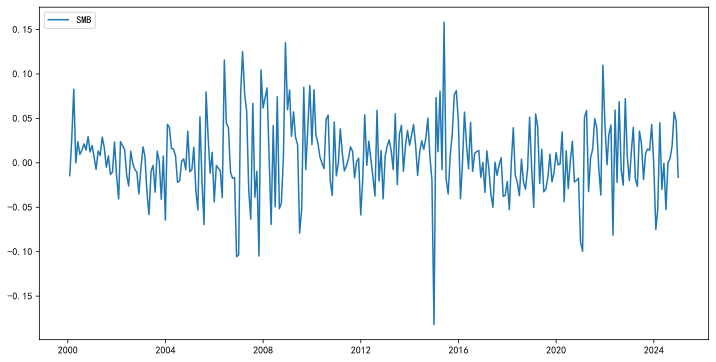

In [ ]:
# plot SMB
fig = plt.figure(figsize=(12,6))
plt.plot(factors['SMB'], label='SMB')
plt.legend(loc='upper left')
plt.show();# 绘制SMB因子时间序列图  

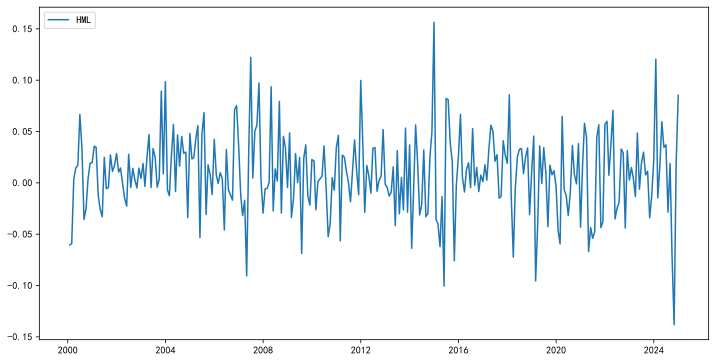

In [115]:
# plot HML
fig = plt.figure(figsize=(12,6))
plt.plot(factors['HML'], label='HML')
plt.legend(loc='upper left')
plt.show();#

In [116]:
# summary of the factor
factors[:'2016-12'].describe()
factors[:'2016-12'].corr()

,MKT,SMB,HML
count,203.000000,203.000000,203.000000
mean,0.008284,0.009550,0.010069
std,0.085793,0.043900,0.037419
min,-0.268349,-0.182035,-0.100553
25%,-0.049183,-0.013224,-0.011374
50%,0.011574,0.007845,0.007437
75%,0.050141,0.030612,0.031613
max,0.296042,0.158098,0.156397


,MKT,SMB,HML
MKT,1.000000,0.218870,-0.319177
SMB,0.218870,1.000000,-0.600943
HML,-0.319177,-0.600943,1.000000


In [118]:
# 对SMB因子进行时间序列回归分析
# 构建回归模型
model = smf.ols(
    'SMB ~ 1',  
    data=factors['2000-01':'2024-12']  # 使用2000年1月到2024年12月的因子数据
).fit(
    cov_type='HAC', 
    cov_kwds={'maxlags': 2}  # HAC估计中的最大滞后阶数设为2
)
# 打印回归结果摘要
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SMB   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                nan
Time:                        19:57:43   Log-Likelihood:                 523.12
No. Observations:                 299   AIC:                            -1044.
Df Residuals:                     298   BIC:                            -1041.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0061      0.003      2.391      0.0

In [119]:
# regression
model = smf.ols('HML ~ 1',
                 data=factors['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 2})
print(model.summary())#同上相似

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                nan
Time:                        19:58:09   Log-Likelihood:                 547.84
No. Observations:                 299   AIC:                            -1094.
Df Residuals:                     298   BIC:                            -1090.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0091      0.002      4.105      0.0

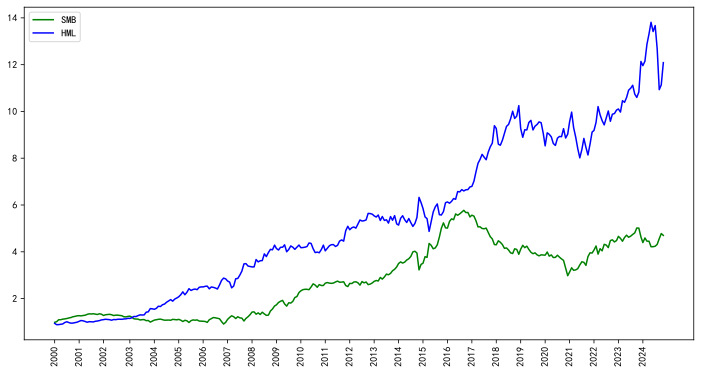

In [121]:
fig = plt.figure(figsize=(12,6))

factors['SMBprice'] = (factors['SMB'] + 1).cumprod()
factors['HMLprice'] = (factors['HML'] + 1).cumprod()

plt.plot(factors['SMBprice'],color='green',label='SMB')
plt.plot(factors['HMLprice'],color='blue',label='HML')
plt.legend(loc='upper left')

xticks = factors.index[::12]
xtick_labels = [label.year for label in xticks]
plt.xticks(xticks, xtick_labels, rotation=90)

plt.show();

In [ ]:
# 计算累积收益率
factors['cumulative_return'] = (1 + factors['SMB']).cumprod()

# 计算滚动最大值
factors['rolling_max'] = factors['cumulative_return'].cummax()

# 计算回撤
factors['drawdown'] = factors['cumulative_return'] / factors['rolling_max'] - 1

# 计算最大回撤
max_drawdown = factors['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.48398211660103563


In [123]:
# 找出最大回撤的时间
max_drawdown_end = factors['drawdown'].idxmin() # 返回 Series 中最小值的索引
max_drawdown_start = factors.loc[:max_drawdown_end, 'cumulative_return'].idxmax() # 这部分代码选择了从数据开始到 max_drawdown_end 时间点之间的所有累积收益率

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Maximum Drawdown Start Date: {max_drawdown_start}")
print(f"Maximum Drawdown End Date: {max_drawdown_end}")

Maximum Drawdown: -0.48398211660103563
Maximum Drawdown Start Date: 2016-10-31 00:00:00
Maximum Drawdown End Date: 2021-01-31 00:00:00


In [ ]:
# 计算累积收益率
factors['cumulative_return'] = (1 + factors['HML']).cumprod()

# 计算滚动最大值
# cummax()计算从开始到当前行的最大值，表示历史最高点
factors['rolling_max'] = factors['cumulative_return'].cummax()

# 计算回撤
factors['drawdown'] = factors['cumulative_return'] / factors['rolling_max'] - 1

# 计算最大回撤
max_drawdown = factors['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.2297015303495128


In [125]:
# 找出最大回撤的时间
max_drawdown_end = factors['drawdown'].idxmin() # 返回 Series 中最小值的索引
max_drawdown_start = factors.loc[:max_drawdown_end, 'cumulative_return'].idxmax() # 这部分代码选择了从数据开始到 max_drawdown_end 时间点之间的所有累积收益率

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Maximum Drawdown Start Date: {max_drawdown_start}")
print(f"Maximum Drawdown End Date: {max_drawdown_end}")

Maximum Drawdown: -0.2297015303495128
Maximum Drawdown Start Date: 2014-12-31 00:00:00
Maximum Drawdown End Date: 2015-05-31 00:00:00


In [126]:
# 构造totalvalue十分组投资策略
def calc_decile_portfolios(data):
    """
    根据totalvalue构造十分组投资组合
    """
    portfolios = {}
    
    # 为每个月的每只股票分配十分组标签
    def assign_decile(group):
        # 计算十分位数
        quantiles = [group['totalvalue'].quantile(i/10) for i in range(11)]
        # 分配到相应的十分组
        labels = pd.cut(group['totalvalue'], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')
        return labels
    
    data_copy = data.copy()
    data_copy['decile'] = data_copy.groupby('month', group_keys=False).apply(
        lambda x: assign_decile(x), include_groups=False
    )
    
    # 计算每个十分组的加权收益率
    for i in range(10):
        decile_name = f'P{i+1}'
        portfolios[decile_name] = (
            data_copy[data_copy['decile'] == i]
            .groupby('month')
            .apply(lambda x: np.average(x['next_ret'], weights=x['totalvalue']), include_groups=False)
            .to_frame(name=decile_name)
        )
    
    return pd.concat(portfolios.values(), axis=1)

# 计算十分组投资组合
decile_portfolios = calc_decile_portfolios(cross_new)
# 调整索引：投资组合收益率应该对应下一个月
decile_portfolios.index = decile_portfolios.index + MonthEnd(1)
decile_portfolios = decile_portfolios['2000-01':]

print("十分组投资组合描述统计:")
decile_portfolios.describe()

十分组投资组合描述统计:


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.012554,0.010585,0.008983,0.008573,0.007849,0.006635,0.008285,0.005746,0.006878,0.006071
std,0.098205,0.095494,0.093805,0.093600,0.091616,0.089693,0.088221,0.085370,0.082370,0.071827
min,-0.314245,-0.314130,-0.308836,-0.314012,-0.313402,-0.297510,-0.301322,-0.311698,-0.276763,-0.259479
25%,-0.042225,-0.042331,-0.043997,-0.044033,-0.045714,-0.046590,-0.042602,-0.042173,-0.041339,-0.039180
50%,0.010255,0.008738,0.004117,0.007982,0.004324,0.005276,0.007032,0.006216,0.003345,0.003414
75%,0.060860,0.059807,0.056578,0.051821,0.054263,0.052511,0.052401,0.046237,0.043487,0.041966
max,0.390600,0.356844,0.335075,0.359422,0.349341,0.330999,0.336158,0.367886,0.322663,0.287096


In [ ]:
# 构建规模因子投资组合：做多最小规模组合(P1)，做空最大规模组合(P10)
decile_portfolios['size_portfolio'] = decile_portfolios['P1'] - decile_portfolios['P10']
decile_portfolios = pd.merge(
    decile_portfolios, 
    factors, 
    left_index=True, 
    right_index=True, 
    how='left'
)
# 检验规模因子是否存在显著的正向收益（α是否显著不为0）
model_size = smf.ols(
    'size_portfolio ~ 1',  # 公式：规模因子组合收益率只对截距项回归
    data=decile_portfolios['2000-01':'2024-12']  # 使用2000-2024年的数据
).fit(
    cov_type='HAC',  # 使用异方差和自相关一致标准误
    cov_kwds={'maxlags': 6}  # 最大滞后阶数设为6，适合月度数据
)

print("模型1：规模因子收益检验（截距模型）")
print("="*60)
print(model_size.summary())
print("\n")

# 检验规模因子收益能否被市场、规模、价值三因子解释
---
model_size_3factors = smf.ols(
    'size_portfolio ~ MKT + SMB + HML',  
    data=decile_portfolios['2000-01':'2024-12']
).fit(
    cov_type='HAC',
    cov_kwds={'maxlags': 6}
)

print("模型2：规模因子的三因子模型检验")
print("="*60)
print(model_size_3factors.summary())

模型1：规模因子收益检验（截距模型）
                            OLS Regression Results                            
Dep. Variable:         size_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                nan
Time:                        20:05:23   Log-Likelihood:                 350.49
No. Observations:                 299   AIC:                            -699.0
Df Residuals:                     298   BIC:                            -695.3
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0065      0.004 

In [128]:
# 构造ep十分组投资策略
def calc_value_decile_portfolios(data):
    """
    根据ep构造十分组投资组合
    """
    portfolios = {}
    
    # 为每个月的每只股票分配十分组标签
    def assign_decile(group):
        # 计算十分位数
        quantiles = [group['ep'].quantile(i/10) for i in range(11)]
        # 分配到相应的十分组
        labels = pd.cut(group['ep'], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')
        return labels
    
    data_copy = data.copy()
    data_copy['ep_decile'] = data_copy.groupby('month', group_keys=False).apply(
        lambda x: assign_decile(x), include_groups=False
    )
    
    # 计算每个十分组的加权收益率
    for i in range(10):
        decile_name = f'V{i+1}'
        portfolios[decile_name] = (
            data_copy[data_copy['ep_decile'] == i]
            .groupby('month')
            .apply(lambda x: np.average(x['next_ret'], weights=x['totalvalue']), include_groups=False)
            .to_frame(name=decile_name)
        )
    
    return pd.concat(portfolios.values(), axis=1)

# 计算十分组投资组合
value_decile_portfolios = calc_value_decile_portfolios(cross_new)
# 调整索引：投资组合收益率应该对应下一个月
value_decile_portfolios.index = value_decile_portfolios.index + MonthEnd(1)
value_decile_portfolios = value_decile_portfolios['2000-01':]

print("价值因子十分组投资组合描述统计:")
value_decile_portfolios.describe()

价值因子十分组投资组合描述统计:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.001624,0.001309,0.000026,0.003986,0.005442,0.006254,0.007162,0.008544,0.006072,0.010568
std,0.092805,0.096791,0.091085,0.087183,0.085640,0.078900,0.080150,0.076042,0.077020,0.077385
min,-0.277141,-0.339272,-0.341337,-0.308362,-0.337108,-0.295875,-0.286992,-0.264207,-0.244541,-0.343513
25%,-0.051639,-0.054280,-0.051910,-0.045470,-0.045339,-0.036668,-0.039806,-0.034942,-0.043129,-0.034174
50%,0.001118,-0.000016,-0.002398,0.001323,0.001254,0.004036,0.006468,0.004547,0.005762,0.009772
75%,0.052908,0.047327,0.048258,0.046286,0.044118,0.046394,0.045936,0.051505,0.043460,0.048555
max,0.353679,0.410985,0.400481,0.296406,0.260486,0.250268,0.336077,0.214670,0.353102,0.288665


In [129]:
value_decile_portfolios['value_portfolio'] = value_decile_portfolios['V10'] - value_decile_portfolios['V1']
value_decile_portfolios = pd.merge(value_decile_portfolios, factors, left_index=True, right_index=True, how='left')
model_value = smf.ols('value_portfolio ~ 1',
                 data=value_decile_portfolios['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_value.summary())
model_value_3factors = smf.ols('value_portfolio ~ MKT + SMB + HML',
                 data=value_decile_portfolios['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_value_3factors.summary())

                            OLS Regression Results                            
Dep. Variable:        value_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                nan
Time:                        20:11:00   Log-Likelihood:                 396.34
No. Observations:                 299   AIC:                            -790.7
Df Residuals:                     298   BIC:                            -787.0
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.003      3.019      0.0

In [130]:
# 构造过去一个月ret十分组投资策略（Reversal效应）
def calc_reversal_decile_portfolios(data):
    """
    根据过去一个月的ret构造十分组投资组合
    """
    portfolios = {}
    
    # 为每个月的每只股票分配十分组标签
    def assign_decile(group):
        # 计算十分位数
        quantiles = [group['ret'].quantile(i/10) for i in range(11)]
        # 分配到相应的十分组
        labels = pd.cut(group['ret'], bins=quantiles, labels=False, include_lowest=True, duplicates='drop')
        return labels
    
    data_copy = data.copy()
    data_copy['ret_decile'] = data_copy.groupby('month', group_keys=False).apply(
        lambda x: assign_decile(x), include_groups=False
    )
    
    # 计算每个十分组的加权收益率
    for i in range(10):
        decile_name = f'R{i+1}'
        portfolios[decile_name] = (
            data_copy[data_copy['ret_decile'] == i]
            .groupby('month')
            .apply(lambda x: np.average(x['next_ret'], weights=x['totalvalue']), include_groups=False)
            .to_frame(name=decile_name)
        )
    
    return pd.concat(portfolios.values(), axis=1)

# 计算十分组投资组合
reversal_decile_portfolios = calc_reversal_decile_portfolios(cross_new)
# 调整索引：投资组合收益率应该对应下一个月
reversal_decile_portfolios.index = reversal_decile_portfolios.index + MonthEnd(1)
reversal_decile_portfolios = reversal_decile_portfolios['2000-01':]

print("Reversal因子十分组投资组合描述统计:")
reversal_decile_portfolios.describe()

Reversal因子十分组投资组合描述统计:


,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.008396,0.007615,0.010808,0.006758,0.008891,0.008460,0.009487,0.007377,0.004381,0.000488
std,0.089563,0.084092,0.078387,0.077746,0.078366,0.081026,0.077920,0.076599,0.082604,0.090767
min,-0.291550,-0.292738,-0.203748,-0.288798,-0.249733,-0.312390,-0.278851,-0.257933,-0.313648,-0.325024
25%,-0.046298,-0.042465,-0.038300,-0.039028,-0.043739,-0.041410,-0.033384,-0.036669,-0.045884,-0.050243
50%,0.004277,0.006495,0.005003,0.006673,0.005490,0.005761,0.008514,0.005599,0.002180,-0.000838
75%,0.054194,0.049229,0.049034,0.044773,0.047159,0.048227,0.049243,0.044495,0.039092,0.046446
max,0.308666,0.293915,0.260822,0.236547,0.333314,0.325007,0.346667,0.254071,0.353734,0.377778


In [131]:
reversal_decile_portfolios['reversal_portfolio'] = reversal_decile_portfolios['R1'] - reversal_decile_portfolios['R10']
reversal_decile_portfolios = pd.merge(reversal_decile_portfolios, factors, left_index=True, right_index=True, how='left')
model_reversal = smf.ols('reversal_portfolio ~ 1',
                 data=reversal_decile_portfolios['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_reversal.summary())
model_reversal_3factors = smf.ols('reversal_portfolio ~ MKT + SMB + HML',
                 data=reversal_decile_portfolios['2000-01':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_reversal_3factors.summary())

                            OLS Regression Results                            
Dep. Variable:     reversal_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 14 Dec 2025   Prob (F-statistic):                nan
Time:                        20:13:08   Log-Likelihood:                 380.35
No. Observations:                 299   AIC:                            -758.7
Df Residuals:                     298   BIC:                            -755.0
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0079      0.004      2.226      0.0